In [1]:
#importing libraries 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from matplotlib.ticker import FixedLocator
from statsmodels.tsa.stattools import adfuller
import itertools
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import TimeSeriesSplit

C:\Users\joypa\AppData\Local\Temp\ipykernel_11952\2531538493.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [21]:
# Read the CSV files into pandas DataFrames
df1 = pd.read_csv('F:/Works/Collaborative Application Development/Day Data/GP21_updated_days.csv')  # Replace with the actual file path
df2 = pd.read_csv('F:/Works/Collaborative Application Development/Day Data/NP21_updated_days.csv')  # Replace with the actual file path

In [22]:
# Drop the 'Date' column from both DataFrames
df1 = df1.drop('Date', axis=1)
df2 = df2.drop('Date', axis=1)

In [23]:
# Extract 'Total Registered' column
total_registered_df1 = df1['Total Registered']
total_registered_df1 = total_registered_df1[-70:]

# Extract 'Total Registered' column
total_registered_df2 = df2['Total Registered']
total_registered_df2 = total_registered_df2[-70:]

In [24]:
# Reset index for both DataFrames
total_registered_df1.reset_index(drop=True, inplace=True)
total_registered_df2.reset_index(drop=True, inplace=True)

In [25]:
# Concatenate the DataFrames along the columns axis
df = pd.concat([total_registered_df1, total_registered_df2], axis=1)
print(df)

    Total Registered  Total Registered
0                  1                 1
1                  1                 1
2                  1                 1
3                 27                 1
4                  8                 1
..               ...               ...
65                 1                 1
66                10                 1
67                19                 1
68                29                 1
69                 2                 2

[70 rows x 2 columns]


In [26]:
# Calculate the mean along the columns axis to combine the values into a single column
df['Total Registered Data'] = df.mean(axis=1).round().astype(int)  # You can replace 'mean' with 'median', 'sum', or any other aggregation function

# Drop the original columns from the concatenated DataFrame
df = df.drop(['Total Registered'], axis=1)

In [27]:
df.reset_index(drop=True, inplace=True)

# Add a new column named "Day" starting from 1
df['Day'] = 'Day ' + (df.index + 1).astype(str)
print(df)

# Save the DataFrame to a CSV file
#df.to_csv('F:/Works/Collaborative Application Development/Merged Dataset (Last 10 Weeks)/Property_Managers.csv', index=False)

    Total Registered Data     Day
0                       1   Day 1
1                       1   Day 2
2                       1   Day 3
3                      14   Day 4
4                       4   Day 5
..                    ...     ...
65                      1  Day 66
66                      6  Day 67
67                     10  Day 68
68                     15  Day 69
69                      2  Day 70

[70 rows x 2 columns]


In [281]:
# Ensure 'Week' is treated as a categorical variable
df['Day'] = df['Day'].astype('category')

# Extract 'Total Registered' column
total_registered = df['Total Registered Data']

In [30]:
#For MSE21

# Load your DataFrame from the CSV file
df = pd.read_csv('F:/Works/Collaborative Application Development/Day Data/MSE21_updated_days.csv')

# Drop unnecessary columns
df = df.drop(['Date', 'Day'], axis=1)

# Extract the last 70 rows from the DataFrame
total_registered = df['Total Registered'].tail(70)

# Create a new DataFrame for the last 70 rows with a new 'Day' column
day_column = ['Day ' + str(i) for i in range(1, len(total_registered) + 1)]
day_df = pd.DataFrame({'Total Registered': total_registered.values, 'Day': day_column})

# Save the DataFrame to a CSV file
#day_df.to_csv('F:/Works/Collaborative Application Development/Merged Dataset (Last 10 Weeks)/Education_Property_Managers.csv', index=False)

# Ensure 'Day' is treated as a categorical variable
day_df['Day'] = day_df['Day'].astype('category')
# Extract 'Total Registered' column
total_registered = day_df['Total Registered']
# Display the DataFrame
print(total_registered)

0     1
1     1
2     1
3     2
4     1
     ..
65    1
66    1
67    1
68    1
69    2
Name: Total Registered, Length: 70, dtype: int64


In [282]:
#pvalue> 0.05 -----> not stationary
#Dickey-Fuller Test

adftest = adfuller(total_registered)
print('pvalue of adfuller test is: ', adftest[1])

pvalue of adfuller test is:  0.2346600005908555


In [283]:
# Check the length of the total_registered series
len(total_registered)

28

In [290]:
#train-test split
train = total_registered[:22]
test = total_registered[22:]

In [291]:
# Define the number of folds for cross-validation
n_splits = 5

In [292]:
# Initialize TimeSeriesSplit for k-fold cross-validation
tscv = TimeSeriesSplit(n_splits=n_splits)

In [293]:
# Initialize lists to store RMSE values for each fold
rmse_scores = []

# Perform k-fold cross-validation
for train_index, test_index in tscv.split(total_registered):
    train, test = total_registered[train_index], total_registered[test_index]
    
    # Fit ARIMA model
    model = ARIMA(train, order=(0, 1, 0)).fit()
    
    # Make predictions
    pred = model.predict(start=test_index[0], end=test_index[-1], typ='levels')
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test, pred))
    rmse_scores.append(rmse)

# Calculate the average RMSE across all folds
average_rmse = np.mean(rmse_scores)
print("Average RMSE:", average_rmse)

Average RMSE: 2.504987562112089


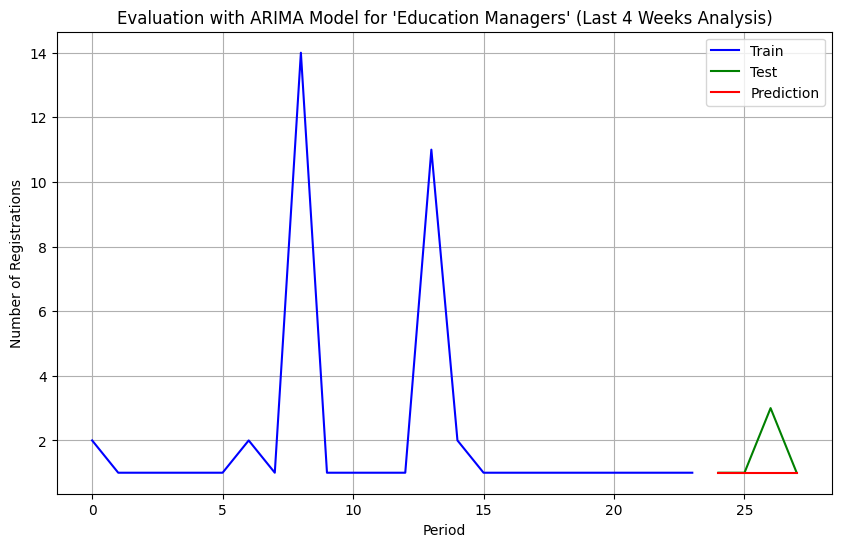

In [294]:
# Plot train, test, and prediction
plt.figure(figsize=(10, 6))
plt.plot(total_registered.index[:len(train)], train, label='Train', color='blue')
plt.plot(total_registered.index[len(train):len(train) + len(test)], test, label='Test', color='green')
plt.plot(total_registered.index[len(train):len(train) + len(test)], pred, label='Prediction', color='red')

# Add labels and title
plt.xlabel('Period')
plt.ylabel('Number of Registrations')
plt.title("Evaluation with ARIMA Model for 'Education Managers' (Last 4 Weeks Analysis)")
plt.legend()
plt.grid(True)

# Save the figure
plt.savefig('F:/Works/Collaborative Application Development/Python/Images/Arima_k-Fold/Merged/Last_4_weeks/Training/Education_Managers_Arima_5-fold_80%.png')

In [295]:
# Fit ARIMA model to the entire dataset
final_model = ARIMA(total_registered, order=(0, 1, 0)).fit()

# Forecast future values for the next 42 days (adjust as needed)
prediction = final_model.predict(len(total_registered), len(total_registered) + 42)
print(prediction)

28    1.0
29    1.0
30    1.0
31    1.0
32    1.0
33    1.0
34    1.0
35    1.0
36    1.0
37    1.0
38    1.0
39    1.0
40    1.0
41    1.0
42    1.0
43    1.0
44    1.0
45    1.0
46    1.0
47    1.0
48    1.0
49    1.0
50    1.0
51    1.0
52    1.0
53    1.0
54    1.0
55    1.0
56    1.0
57    1.0
58    1.0
59    1.0
60    1.0
61    1.0
62    1.0
63    1.0
64    1.0
65    1.0
66    1.0
67    1.0
68    1.0
69    1.0
70    1.0
Name: predicted_mean, dtype: float64


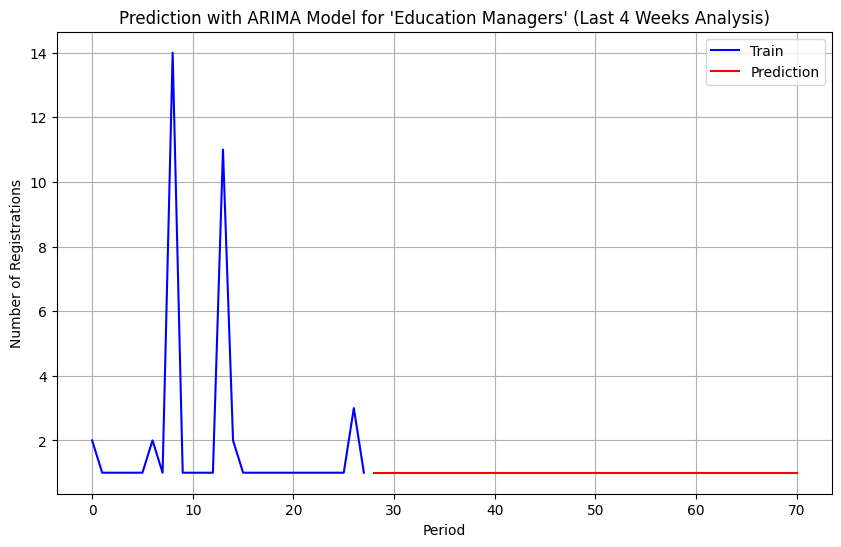

In [296]:
#Plotting the prediction graph
total_registered.plot(legend = True, label = 'Train', color='blue', figsize = (10, 6))
prediction.plot(legend = True, label = 'Prediction', color='red')

# Add labels and title
plt.xlabel('Period')
plt.ylabel('Number of Registrations')
plt.title("Prediction with ARIMA Model for 'Education Managers' (Last 4 Weeks Analysis)")
plt.grid(True)

# Save the figure
plt.savefig('F:/Works/Collaborative Application Development/Python/Images/Arima_k-Fold/Merged/Last_4_weeks/Prediction/Education_Managers_Arima_5-fold_80%.png')

In [ ]:
#..............................................Finding optimal Hyperparameters..................................................#

In [285]:
# Define the number of folds for cross-validation
n_splits = 5  # You can adjust this number based on your preference

# Define the range for p, d, and q
p_range = range(0, 8)
d_range = range(0, 2)
q_range = range(0, 8)

# Generate all possible combinations of p, d, and q
pdq_combinations = list(itertools.product(p_range, d_range, q_range))

# Initialize lists to store results
rmse_scores = []
parameter_combinations = []

# Initialize TimeSeriesSplit for k-fold cross-validation
tscv = TimeSeriesSplit(n_splits=n_splits)

# Perform k-fold cross-validation
for pdq in pdq_combinations:
    rmse_scores_fold = []
    for train_index, test_index in tscv.split(total_registered):
        train = total_registered[train_index]
        test = total_registered[test_index]
        try:
            # Fit ARIMA model and make predictions
            model = ARIMA(train, order=pdq).fit()
            pred = model.predict(start=test.index[0], end=test.index[-1], typ='levels')
            # Calculate RMSE for each fold
            rmse_fold = np.sqrt(mean_squared_error(test, pred))
            rmse_scores_fold.append(rmse_fold)
        except Exception as e:
            print(f'Error fitting model for parameter {pdq}: {str(e)}')
            continue
    if rmse_scores_fold:
        # Calculate the mean RMSE across all folds for the current parameter combination
        mean_rmse = np.mean(rmse_scores_fold)
        # Append mean RMSE and corresponding parameter combination to lists
        rmse_scores.append(mean_rmse)
        parameter_combinations.append(pdq)

# Create a DataFrame to store the results
result_df = pd.DataFrame({'Parameter': parameter_combinations, 'Mean RMSE': rmse_scores})

# Sort the DataFrame by Mean RMSE
result_df = result_df.sort_values(by='Mean RMSE')

# Print the DataFrame
print(result_df)

Error fitting model for parameter (5, 1, 4): LU decomposition error.
Error fitting model for parameter (6, 1, 1): LU decomposition error.
Error fitting model for parameter (6, 1, 4): LU decomposition error.
Error fitting model for parameter (7, 1, 0): LU decomposition error.
Error fitting model for parameter (7, 1, 1): LU decomposition error.
Error fitting model for parameter (7, 1, 5): LU decomposition error.
Error fitting model for parameter (7, 1, 7): LU decomposition error.
     Parameter  Mean RMSE
108  (6, 1, 4)   2.481984
8    (0, 1, 0)   2.504988
24   (1, 1, 0)   2.512675
127  (7, 1, 7)   2.572091
121  (7, 1, 1)   2.611485
..         ...        ...
101  (6, 0, 5)   3.748679
86   (5, 0, 6)   3.864903
125  (7, 1, 5)   3.906564
100  (6, 0, 4)   3.929722
102  (6, 0, 6)   3.931924

[128 rows x 2 columns]
